![](img/563_banner.png)

# Lecture 5: Word Embeddings, word2vec
UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Lecture plan, imports, LOs

### Lecture plan 

- Introduction and motivation (~5 mins)
- Summary of pre-watch videos (~20 mins)
- Demo of word2vec skipgram (extremely inefficient version) on a toy corpus (~10 mins)
- Q&A and T/F questions (~5 mins )
- Break (~5 mins)
- Training word2vec (~10 mins)
- Word analogies, biases and stereotypes in word embeddings (~10 mins)
- Q&A and T/F questions (~5 mins )
- Final comments, summary, reflection (~5 mins) 

<br><br><br><br>

### Imports 

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath("."), "code"))

import matplotlib.pyplot as plt
from comat import CooccurrenceMatrix
from preprocessing import MyPreprocessor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
# from support_functions import *

plt.rcParams["font.size"] = 16
import matplotlib.cm as cm

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

### Learning outcomes

From this lecture, students are expected to be able to:

- Explain the general idea of a vector space model.
- Explain the difference between different word representations: one-hot encoding, term-term co-occurrence matrix representation, and word2vec representation. 
- Explain the skip-gram model at a high level.
- Load and use pre-trained word embeddings to find word similarities and analogies.  
- Train your own word vectors with `Gensim`.
- Use word2vec models for word similarity and analogies.
- Demonstrate biases in word2vec models and learn to watch out for such biases in pre-trained embeddings.  

<br><br><br><br>

## 1. Motivation and context

- Do large language models, such as ChatGPT, "understand" your questions to some extent and provide useful responses?
- What is required for a machine to "understand" language?
  
- Last week, we discussed representing numeric data with PCA and text with LSA or TruncatedSVD.
  
- So far we have been talking about sentence or document representations. 
- This week, we'll go one step back and talk about word representations. 
- Why? Because word is a basic semantic unit of text and in order to capture meaning of text it is useful to capture word meaning (e.g., in terms of relationships between words).  

### 1.1 Activity: Context and word meaning 

- Pair up with the person next to you and try to guess the meanings of two made-up words: **flibbertigibbet** and **groak**.


> 1. The plot twist was totally unexpected, making it a **flibbertigibbet** experience.
> 2. Despite its **groak** special effects, the storyline captivated my attention till the end.
> 3. I found the character development rather **groak**, failing to evoke empathy.
> 4. The cinematography is **flibbertigibbet**, showcasing breathtaking landscapes.
> 5. A **groak** narrative that could have been saved with better direction.
> 6. This movie offers a **flibbertigibbet** blend of humour and action, a must-watch.
> 7. Sadly, the movie's potential was overshadowed by its **groak** pacing.
> 8. The soundtrack complemented the film's theme perfectly, adding to its **flibbertigibbet** charm.
> 9. It's rare to see such a **flibbertigibbet** performance by the lead actor.
> 10. Despite high expectations, the film turned out to be quite **groak**.
> 11. **Flibbertigibbet** dialogues and a gripping plot make this movie stand out.
> 12. The film's **groak** screenplay left much to be desired.

Attributions: Thanks to ChatGPT! 

- How did you infer the meaning of the words **flibbertigibbet** and **groak**?
- Which specific words or phrases in the context helped you infer the meaning of these imaginary words? 

<br><br><br><br>

What you did in the above activity is referred to as **distributional hypothesis**. 

<blockquote> 
    <p>You shall know a word by the company it keeps.</p>
    <footer>Firth, 1957</footer>        
</blockquote>

<blockquote> 
If A and B have almost identical environments we say that they are synonyms.
<footer>Harris, 1954</footer>    
</blockquote>    

Example: 

- The plot twist was totally unexpected, making it a **flibbertigibbet** experience.
- The plot twist was totally unexpected, making it a **delightful** experience.

### 1.2 Word representations: intro 
- A standard way to represent meanings of words is by placing them into a vector space.
- Distances between words in the vector space indicate relationships between them.
   
<!-- <img src="img/t-SNE_word_embeddings.png" width="600" height="600"> -->

![](img/t-SNE_word_embeddings.png)
 
(Attribution: [Jurafsky and Martin 3rd edition](https://web.stanford.edu/~jurafsky/slp3/))

- Word meaning has been a favourite topic of philosophers for centuries. 
- An example from legal domain: [Are hockey gloves "gloves, mittens, mitts" or "articles of plastics"?](https://www.scc-csc.ca/case-dossier/info/sum-som-eng.aspx?cas=36258)

<blockquote>
Canada (A.G.) v. Igloo Vikski Inc. was a tariff code case that made its way to the SCC (Supreme Court of Canada). The case disputed the definition of hockey gloves as either "gloves, mittens, or mitts" or as "other articles of plastic."
</blockquote>

![](img/hockey_gloves_case.png)
<!-- <center>
<img src="img/hockey_gloves_case.png" width="500" height="500">
</center>
 -->

In ML and Natural Language Processing (NLP) we are interested in 
- Modeling word meaning that allows us to 
    - draw useful inferences to solve meaning-related problems 
    - find relationship between words, e.g., which words are similar, which ones have positive or negative connotations
    

**Example: Word similarity**

- Suppose you are carrying out sentiment analysis. 
- Consider the sentences below. 

> S1: This movie offers a **flibbertigibbet** blend of humour and action, a must-watch.

> S2: This movie offers a **delightful** blend of humour and action, a must-watch.

- Here we would like to capture similarity between **flibbertigibbet** and **delightful** in reference to sentiment analysis task. 

**How are word embeddings related to unsupervised learning?**

- They are closely related to dimensionality reduction and extracting meaningful representations from raw data. 
- The word2vec algorithm is an unsupervised (or semi-supervised) method; we do not need any labeled data but we use running text as supervision signal.
- We can build recommendation systems using word2vec algorithm (you'll explore this in the lab) which is the topic of next week.   

<br><br><br><br>

## 2. Word representations

### Activity:  Brainstorm ways to represent words (~2 mins) 

- Suppose you are building a question answering system and you are given the following question and three candidate answers. 
- What kind of relationship between words would we like our representation to capture in order to arrive at the correct answer?  
    
<blockquote>       
<p style="font-size:20px"><b>Question:</b> How <b>tall</b> is Machu Picchu?</p>
    <p style="font-size:20px"><b>Candidate 1:</b> Machu Picchu is 13.164 degrees south of the equator.</p>    
<p style="font-size:20px"><b>Candidate 2:</b> The official height of Machu Picchu is 2,430 m.</p>
<p style="font-size:20px"><b>Candidate 3:</b> Machu Picchu is 80 kilometres (50 miles) northwest of Cusco.</p>    
</blockquote> 
    

- Let's explore different ways to represent words. 
- First, let's look at two simplistic word representations  
    - One-hot representation
    - Term-term co-occurrence matrix

### 2.1 Simplest representation: One-hot representation of words 

- Example: Consider the sentence
> How tall is Machu_Picchu ?

- What is the one-hot representation for the word *tall*?
    * Vocabulary size = 5 and index of the word *tall* = 1
    * One-hot vector for *tall*: $\begin{bmatrix} 0 & 1 & 0 & 0 & 0 \end{bmatrix}$
    
- Build **vocabulary** containing all unique words in the corpus. 
- One-hot representation of a word is a vector of length $V$ such that the value at word index is 1 and all other indices is 0.    

In [2]:
def get_onehot_encoding(word, vocab):
    onehot = np.zeros(len(vocab), dtype="float64")
    onehot[vocab[word]] = 1
    return onehot

In [3]:
from sklearn.metrics.pairwise import cosine_similarity


def print_cosine_similarity(df, word1, word2):
    """
    Returns similarity score between word1 and word2
    Arguments
    ---------
    df    -- (pandas.DataFrame)
        Dataframe containing word representations
    word1 -- (array)
        Representation of word1
    word2 -- (array)
        Representation of word2

    Returns
    --------
    None. Returns similarity score between word1 and word2 with the given representation
    """
    vec1 = df.loc[word1].values.reshape(1, -1)
    vec2 = df.loc[word2].values.reshape(1, -1)
    sim = cosine_similarity(vec1, vec2)
    print(
        "The dot product between %s and %s: %0.2f and cosine similarity is: %0.2f"
        % (word1, word2, np.dot(vec1.flatten(), vec2.flatten()), sim[0][0])
    )

**Vocabulary and one-hot encoding**

In [4]:
corpus = (
    """how tall is machu_picchu ? the official height of machu_picchu is 2,430 m ."""
)
unique_words = list(set(corpus.split()))
unique_words.sort()
vocab = {word: index for index, word in enumerate(unique_words)}
print("Size of the vocabulary: %d" % (len(vocab)))
print(vocab)

Size of the vocabulary: 12
{'.': 0, '2,430': 1, '?': 2, 'height': 3, 'how': 4, 'is': 5, 'm': 6, 'machu_picchu': 7, 'of': 8, 'official': 9, 'tall': 10, 'the': 11}


In [5]:
data = {}
for word in vocab:
    data[word] = get_onehot_encoding(word, vocab)
ohe_df = pd.DataFrame(data).T
ohe_df

,0,1,2,3,4,5,6,7,8,9,10,11
.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2,430",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
?,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
height,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
how,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
m,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
machu_picchu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
of,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
official,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
print_cosine_similarity(ohe_df, "tall", "height")
print_cosine_similarity(ohe_df, "tall", "official")

The dot product between tall and height: 0.00 and cosine similarity is: 0.00
The dot product between tall and official: 0.00 and cosine similarity is: 0.00


**Problem with one-hot encoding**

- We would like the word representation to capture the similarity between _tall_ and _height_ and so we would like them to have bigger dot product or bigger cosine similarity (normalized dot product). 
- The problem with one-hot representation of words is that there is no inherent notion of relationship between words and the dot product between similar and non-similar words is zero.

$$ 
\vec{tall}\cdot\vec{height} = 0\\ 
$$

**Need a representation that captures relationships between words.**

- We will be looking at two such representations.  
    1. Sparse representation with **term-term co-occurrence matrix**
    2. Dense representation with **word2vec skip-gram model**

### 2.2 Term-term co-occurrence matrix

- So far we have been talking about documents and we created document-term co-occurrence matrix (e.g., bag-of-words representation of text). 
- We can also do this with words. The idea is to go through a corpus of text, keeping a count of all of the words that appear in context of each word (within a window).

**Visualizing word vectors and similarity**

![](img/word_vectors_and_angles.png)
<!-- <center>
<img src="img/word_vectors_and_angles.png" width="800" height="800">
</center>
     -->
(Credit: Jurafsky and Martin 3rd edition)

- The similarity is calculated using dot products between word vectors.
    - Example: $\vec{\text{digital}}.\vec{\text{information}} = 0 \times 1 + 1\times 6 = 6$
    - Higher the dot product more similar the words.

- The similarity is calculated using dot products between word vectors.
    - Example: $\vec{\text{digital}}.\vec{\text{information}} = 0 \times 1 + 1\times 6 = 6$
    - Higher the dot product more similar the words.

- We can also calculate a normalized version of dot products. 
    $$similarity_{cosine}(w_1,w_2) = \frac{w_1.w_2}{\left\lVert w_1\right\rVert_2 \left\lVert w_2\right\rVert_2}$$


In [7]:
corpus = [
    "How tall is Machu Picchu?",
    "Machu Picchu is 13.164 degrees south of the equator.",
    "The official height of Machu Picchu is 2,430 m.",
    "Machu Picchu is 80 kilometres (50 miles) northwest of Cusco.",
    "It is 80 kilometres (50 miles) northwest of Cusco, on the crest of the mountain Machu Picchu, located about 2,430 metres (7,970 feet) above mean sea level, over 1,000 metres (3,300 ft) lower than Cusco, which has an elevation of 3,400 metres (11,200 ft).",
]
sents = MyPreprocessor(corpus)

In [8]:
cm = CooccurrenceMatrix(
    sents, window_size=2
)  # Let's build term-term co-occurrence matrix for our text.
comat = cm.fit_transform()
vocab = cm.get_feature_names()
df = pd.DataFrame(comat.todense(), columns=vocab, index=vocab, dtype=np.int8)
df.head()

,tall,machu,picchu,13.164,degrees,south,equator,official,height,"2,430",...,mean,sea,level,"1,000","3,300",ft,lower,elevation,"3,400","11,200"
tall,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
machu,1,0,5,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
picchu,1,5,0,1,1,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
13.164,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
degrees,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print_cosine_similarity(df, "tall", "height")
print_cosine_similarity(df, "tall", "official")

The dot product between tall and height: 2.00 and cosine similarity is: 0.82
The dot product between tall and official: 1.00 and cosine similarity is: 0.50


- We are getting non-zero cosine similarity now and we are able to capture some similarities between words now. 
- That said similarities do not make much sense in the toy example above because we're using a tiny corpus. 
- To find meaningful patterns of similarities between words, we need a large corpus. 
- Let's try a bit larger corpus and check whether the similarities make sense. 

In [10]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

corpus = []

queries = [
    "Machu Picchu",
  # "Everest",
    "Sequoia sempervirens",
    "President (country)",
    "Politics Canada",
]

for i in range(len(queries)):
    sents = sent_tokenize(wikipedia.page(queries[i]).content)
    corpus.extend(sents)
print("Number of sentences in the corpus: ", len(corpus))

Number of sentences in the corpus:  709


In [11]:
sents = MyPreprocessor(corpus)
cm = CooccurrenceMatrix(sents)
comat = cm.fit_transform()
vocab = cm.get_feature_names()
df = pd.DataFrame(comat.todense(), columns=vocab, index=vocab, dtype=np.int8)
df

,machu,picchu,15th-century,inca,citadel,located,eastern,cordillera,southern,peru,...,comprehensive,overview,cbc,digital,archives,boondoggles,elephants,campaigning,compared,textbook
machu,0,79,1,5,1,2,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
picchu,79,0,1,6,3,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
15th-century,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
inca,5,6,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
citadel,1,3,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
boondoggles,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
elephants,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0
campaigning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
compared,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print_cosine_similarity(df, "tall", "height")
print_cosine_similarity(df, "tall", "official")

The dot product between tall and height: 18.00 and cosine similarity is: 0.33
The dot product between tall and official: 0.00 and cosine similarity is: 0.00


<br><br><br><br>

## 3. Dense representations 

- The goal is to learn general purpose embeddings that are useful for common tasks involving text data. 

**Sparse vs. dense word vectors**
- Term-term co-occurrence matrix representation is long and sparse. 
    - length |V| is usually large (e.g., > 50,000) 
    - most elements are zero
- OK because there are efficient ways to deal with sparse matrices.

- Learn short (~100 to 1000 dimensions) and dense vectors.  
- Short vectors are usually easier to train with ML models (less weights to train).
- They may generalize better.
- In practice they work much better! 

### 3.1 What can we do with these word representations

- Before looking at how to create dense word representations let's see how they look like and 
what can we do with them. 
- Below I am loading word vectors trained on Google News corpus. 

In [13]:
# It'll take a while to run this when you try it out for the first time.
import gensim.downloader as api

google_news_vectors = api.load("word2vec-google-news-300")

In [14]:
print("Size of vocabulary: ", len(google_news_vectors))

Size of vocabulary:  3000000


- `google_news_vectors` above has 300 dimensional word vectors for 3,000,000 unique words from Google news. 

- Let's examine word vector for the word UBC. 

In [15]:
google_news_vectors["UBC"][:20]  # Representation of the word UBC

array([-0.3828125 , -0.18066406,  0.10644531,  0.4296875 ,  0.21582031,
       -0.10693359,  0.13476562, -0.08740234, -0.14648438, -0.09619141,
        0.02807617,  0.01409912, -0.12890625, -0.21972656, -0.41210938,
       -0.1875    , -0.11914062, -0.22851562,  0.19433594, -0.08642578],
      dtype=float32)

In [16]:
google_news_vectors["UBC"].shape

(300,)

Indeed it is a short and a dense vector! 

**Finding similar words**

- Given word $w$, search in the vector space for the word closest to $w$ as measured by cosine distance. 

In [17]:
google_news_vectors.most_similar("UBC")

[('UVic', 0.788647472858429),
 ('SFU', 0.7588527202606201),
 ('Simon_Fraser', 0.7356573939323425),
 ('UFV', 0.6880434155464172),
 ('VIU', 0.6778583526611328),
 ('Kwantlen', 0.6771427989006042),
 ('UBCO', 0.6734487414360046),
 ('UPEI', 0.6731125116348267),
 ('UBC_Okanagan', 0.6709135174751282),
 ('Lakehead_University', 0.662250816822052)]

In [18]:
google_news_vectors.most_similar("information")

[('info', 0.7363681793212891),
 ('infomation', 0.680029571056366),
 ('infor_mation', 0.6733849048614502),
 ('informaiton', 0.6639008522033691),
 ('informa_tion', 0.6601257920265198),
 ('informationon', 0.633933424949646),
 ('informationabout', 0.6320980787277222),
 ('Information', 0.6186580657958984),
 ('informaion', 0.6093292236328125),
 ('details', 0.6063088178634644)]

If you want to extract all documents containing words similar to **information**, you could use this information.  

Google News embeddings also support multi-word phrases. 

In [19]:
google_news_vectors.most_similar("British_Columbia")

[('BC', 0.7640387415885925),
 ('Alberta', 0.7285022735595703),
 ('Ontario', 0.7031311392784119),
 ('Vancouver', 0.6976040005683899),
 ('Lower_Mainland', 0.6730169057846069),
 ('Saskatchewan', 0.6690970063209534),
 ('Manitoba', 0.6569437980651855),
 ('Canada', 0.6478375792503357),
 ('Kamloops', 0.6449971795082092),
 ('Nanaimo_BC', 0.6426822543144226)]

**Finding similarity scores between words**

In [20]:
google_news_vectors.similarity("Canada", "hockey")

0.27610135

In [21]:
google_news_vectors.similarity("Japan", "hockey")

0.0019627833

In [22]:
word_pairs = [
    ("height", "tall"),
    ("height", "official"),
    ("pineapple", "mango"),
    ("pineapple", "juice"),
    ("sun", "robot"),
    ("GPU", "hummus"),
]
for pair in word_pairs:
    print(
        "The similarity between %s and %s is %0.3f"
        % (pair[0], pair[1], google_news_vectors.similarity(pair[0], pair[1]))
    )

The similarity between height and tall is 0.473
The similarity between height and official is 0.002
The similarity between pineapple and mango is 0.668
The similarity between pineapple and juice is 0.418
The similarity between sun and robot is 0.029
The similarity between GPU and hummus is 0.094


We are getting reasonable word similarity scores!! 

<br><br>

### 3.2 Creating dense representations

![](img/word2vec.png)
<!-- <center>
<img src="img/word2vec.png" width="600" height="600">
</center>    
 -->
There are two classes of approaches. 

- LSA (also referred to as count-based approaches)
- word2vec (prediction-based approaches)


#### 3.2.1 (Optional) Dense embeddings with LSA

- How can we get such dense word embeddings? 
- Can we use LSA to get such short and dense representations? 

In [23]:
import nltk
from sklearn.decomposition import TruncatedSVD

In [24]:
cm = CooccurrenceMatrix(sents)
comat = cm.fit_transform()
vocab = cm.get_feature_names()

In [25]:
lsa = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
lsa.fit(comat)
embedding_matrix = lsa.transform(comat)
lsa_rep_df = pd.DataFrame(embedding_matrix, index=vocab)

In [26]:
lsa_rep_df  # word representations learned with LSA

,0,1,2,3,4,5,6,7,8,9
machu,59.744787,-56.048148,-9.476625,-2.125471,-0.931832,0.091583,0.016552,0.123792,-0.092774,0.092224
picchu,61.156957,57.356851,-10.068306,-2.102533,-1.328928,-1.133096,1.270330,-0.369837,0.059576,0.420707
15th-century,1.425137,-0.004821,-0.271348,-0.060159,-0.064429,0.009745,-0.011915,-0.053462,0.043515,-0.009831
inca,9.689077,-0.487520,-0.900727,-0.141428,-0.458294,0.374853,-0.345878,-0.262844,0.506327,-0.231733
citadel,2.995572,-1.302157,-0.468748,-0.161603,-0.264666,0.101359,-0.069382,-0.273455,-0.001200,0.171081
...,...,...,...,...,...,...,...,...,...,...
boondoggles,0.023089,-0.000278,0.045347,0.017567,-0.036114,-0.016962,0.023338,0.042295,0.014989,-0.018444
elephants,0.006440,-0.000364,0.037552,-0.015651,-0.026522,-0.020554,0.013983,0.052387,0.015443,-0.012910
campaigning,0.080149,0.005431,0.468662,-0.241442,-0.180483,0.207737,-0.182761,0.357888,0.178600,0.101775
compared,0.078030,0.005072,0.567311,-0.333567,-0.222730,0.195864,-0.187922,0.471011,0.309136,0.103632


In [27]:
print_cosine_similarity(lsa_rep_df, "tall", "height")
print_cosine_similarity(lsa_rep_df, "tall", "official")

The dot product between tall and height: 6.53 and cosine similarity is: 1.00
The dot product between tall and official: 0.02 and cosine similarity is: 0.00


### 3.2.2 word2vec

- We can use LSA to get dense word embeddings.
- In general, if we have a small dataset, embeddings extracted using LSA work better. 
- But an alternative and a more popular way to extract dense and short embeddings is using word2vec.  
- word2vec is a family of algorithms to create dense word embeddings using neural networks.

**word2vec task**

Remember fill in the blank puzzles in your highschool tests? 

> Add freshly squeezed ___ juice to your smoothie. 
1. pineapple 
2. scarf
3. PCA
4. earthquake 

Another slightly non-intuitive way to think about this is what would be the context words given the target word **pineapple**?    

> Add freshly ___ **pineapple** ___ to your smoothie. 

word2vec learns meaningful word representations by learning to solve large number of such fill in the blank puzzles.  

- Based on this intuition, there are two primary algorithms 
    - Continuous bag of words (CBOW)
    - **Skip-gram**
- Two moderately efficient training methods 
    - Hierarchical softmax
    - Negative sampling 

**word2vec: Skip-gram model**

- We are going to talk about the inefficient Skip-gram model, as it's enough to get an intuition. 
- A neural network model to obtain short and dense representations of words. 
- A simple architecture with 
    - an input layer
    - a linear hidden layer (without any activation function)
    - an output layer with softmax 

- In skip-gram we work on an "auxiliary" supervised machine learning word prediction task of prediction context words given the target word.   
- We train a neural network for this task and the learned weights are our word vectors. 
- So we are not actually interested in making prediction about the context words. 
- Our goal is to learn meaningful weights (meaningful representation of the input) in the process. 

<blockquote>
    Add freshly squeezed$_{context}$ pineapple$_{target}$ juice$_{context}$ to your smoothie. 
</blockquote> 

![](img/target-context.png)

<!-- <center>
<img src="img/target-context.png" width="300" height="300">
</center>
 -->
- So in the example above given the target word **pineapple**
    - what's the probability that a randomly picked context word is **juice**. 
    - what's the probability that a randomly picked context word is **squeezed**. 

- Given a **target word** (i.e., center word) word, predict **context words** (i.e., surrounding words). 
- Note that we are using "target" in a different sense here compared to how we use it in supervised machine learning.  

**A simple neural network architecture ([Source](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/))**

- an input layer
- a linear hidden layer (without any activation function)
- an output layer with softmax

![](img/word2vec_skipgram.png)

<!-- <img src="img/word2vec_skipgram.png" width="600" height="800"> -->

<!-- <center>
<img src="img/word2vec_skipgram.png" width="500" height="500">
</center>    
 -->
<br><br>

<!-- <img src="img/skipgram-juice.png" width="1000" height="1000"> -->

![](img/skipgram-juice.png)

<br><br>

![](img/skipgram-squeezed.png)

**Skip-gram objective**

- Consider the conditional probabilities $p(w_c|w_t)$ and set the parameters $\theta$ of $p(w_c|w_t; \theta)$ so as to maximize the corpus probability. 

$$\arg \max\limits_\theta \prod\limits_{(w_c,w_t) \in D} p(w_c|w_t;\theta)$$


- $w_t$ &rarr; target word
- $w_c$ &rarr; context word
- $D$ &rarr; the set of all target and context pairs from the text 
- $V$ &rarr; vocabulary

- Model the conditional probability using softmax of the dot product.
    * Higher the dot product higher the probability and vice-versa.     
    

$$P(w_c|w_t;\theta) = \frac{e^{w_c.w_t}}{\sum\limits_{\substack{c' \in V}} e^{w_{c'}.w_t}}$$

- Substituting the conditional probability with the softmax of dot product: 
$$ \arg \max\limits_\theta \prod\limits_{(w_c,w_t) \in D} P(w_c|w_t;\theta) \approx \prod\limits_{(w_c,w_t) \in D} \frac{e^{w_c.w_t}}{\sum\limits_{\substack{c' \in V}} e^{w_{c'}.w_t}}$$
- Assumption: Maximizing this objective on a large corpus will result in meaningful embeddings for all words in the vocabulary. 

**Main hyperparameters of the model**

- Dimensionality of the word vectors 
- Window size
    * shorter window: more syntactic representation
    * longer window: more semantic representation 
    * Mikolov et al. (2015) suggest setting this parameter in the range 5 to 20 for small training datasets and in the range 2 to 5 for large training datasets.    

**(Optional) Parameters to learn**

- Given a corpus with vocabulary of size $V$, where a word $w_i$ is identified by its index $i \in {1, ..., V}$, learn a vector representation for each $w_i$ by predicting the words that appear in its context. 
- Learn the following parameters of the model
    - Suppose $V = 10,000$, $d = 300$, the number of parameters to learn are 6,000,000! 

$$
\theta = 
\begin{bmatrix} aardvark_t\\
                aback_t\\
                \dots\\
                zymurgi_t\\
                aardvark_c\\
                aback_c\\                
                \dots\\
                zymurgi_c\\                
\end{bmatrix} \in R^{2dV}
$$


<br><br><br><br>

<br><br><br><rb>

## ❓❓ Questions for you

### Exercise 5.1 Select all of the following statements which are **True** (iClicker)

- (A) Word representation created by term-term co-occurrence matrix are long and sparse whereas the ones created by word2vec are short and dense. 
- (B) You could pass term-term co-occurrence matrix to `TruncatedSVD` or LSA to get short and dense representations. 
- (C) The word2vec algorithm does not require any manually labeled training data.
- (D) When training a word2vec model, it is fine if we do poorly on the fake word prediction task because in the end we only care about the learned weights of the model.
- (E) Given the following table (word 1, word 2) are more similar than (word 1, word 3) in terms of dot products. 

![](img/similarity_question.png)
<!-- <img src="img/similarity_question.png" width="500" height="500"> -->

```{admonition} V's Solutions
:class: tip, dropdown
- A, B, C
```

<br><br><br><br>

## 4. More word2vec

### 4.1 Skip-gram demo with toy data

**For the purpose of your lab or quiz, you do not have to understand the code in this demo.** 

In [28]:
toy_corpus = [
    "drink mango juice",
    "drink pineapple juice",
    "drink apple juice",
    "drink squeezed pineapple juice",
    "drink squeezed mango juice",
    "drink apple tea",
    "drink mango tea",
    "drink mango water",
    "drink apple water",
    "drink pineapple water",
    "drink juice",
    "drink water",
    "drink tea",
    "play hockey",
    "play football",
    "play piano",
    "piano play",
    "play hockey game",
    "play football game",
]

In [29]:
sents = MyPreprocessor(toy_corpus)  # memory smart generator

In [30]:
EMBEDDING_DIM = 10
CONTEXT_SIZE = 2
EPOCHS = 10

In [31]:
from word2vec_demo import *

vocab = get_vocab(sents)
word2idx = {w: idx for (idx, w) in enumerate(vocab)}
idx2word = {idx: w for (idx, w) in enumerate(vocab)}

vocab_size = len(vocab)

In [32]:
vocab

['piano',
 'juice',
 'tea',
 'apple',
 'pineapple',
 'drink',
 'hockey',
 'game',
 'football',
 'play',
 'water',
 'mango',
 'squeezed']

In [33]:
idx_pairs = create_input_pairs(sents, word2idx)    
idx_pairs[:10] # training examples

array([[ 5, 11],
       [ 5,  1],
       [11,  5],
       [11,  1],
       [ 1,  5],
       [ 1, 11],
       [ 5,  4],
       [ 5,  1],
       [ 4,  5],
       [ 4,  1]])

In [34]:
model = SkipgramModel(len(vocab), EMBEDDING_DIM)
train_skipgram(model, idx_pairs, epochs=10)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [35]:
from IPython.display import display

Column
    [0] Column
        [0] IntSlider(end=1000, step=100)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00118')
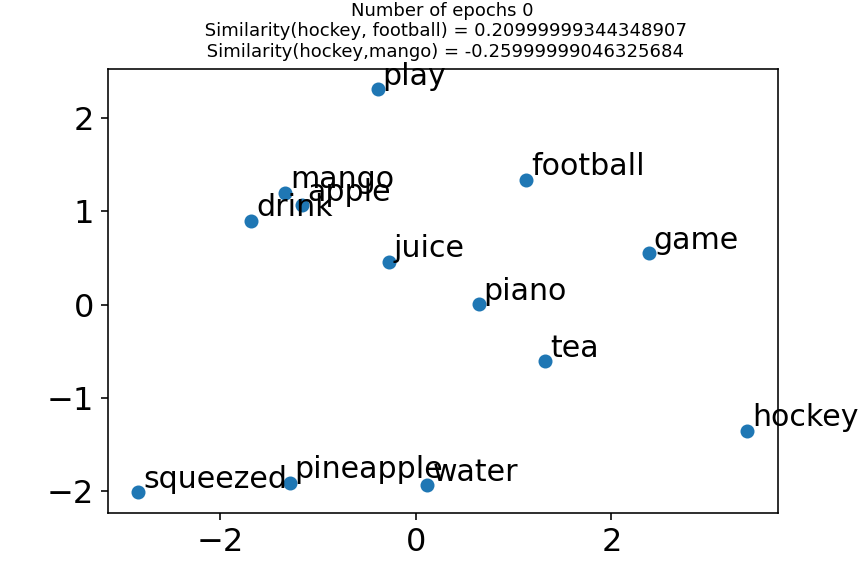

In [36]:
import panel as pn
from panel import widgets
from panel.interact import interact
import matplotlib

pn.extension()

def f(n_epochs):
    fig = plt.figure(figsize=(6, 4))    
    return plot_embeddings(fig, n_epochs, model, idx_pairs, vocab, word2idx)

#interact(f, angle=widgets.IntSlider(start=0, end=182, step=1, value=0))
interact(f, n_epochs=widgets.IntSlider(start=0, end=1000, step=100, value=0))#.embed(max_opts=200)

<br><br><br><br>

**Skip-gram before the weights are trained**
<img src="img/word2vec-toy-epochs0.png" width="1000" height="1000">

<!-- <center>
<img src="img/word2vec-toy-epochs0.png" width="1000" height="1000">
</center>     -->

**Skip-gram after 900 epochs**

<img src="img/word2vec-toy-epochs900.png" width="1000" height="1000">

<!-- <center>
<img src="img/word2vec-toy-epochs900.png" width="1000" height="1000">
</center>     -->

### 4.2 Training word2vec embeddings

- [Original C code](https://code.google.com/archive/p/word2vec/) 
- [GitHub version of the code](https://github.com/tmikolov/word2vec)
- [Gensim](https://radimrehurek.com/gensim/), an open source Python library that provides a Python interface for word2vec family of algorithms

You can install it as follows: 

```
> conda activate 563
> conda install conda-forge::gensim
```

In [37]:
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
sentences

[['cat', 'say', 'meow'], ['dog', 'say', 'woof']]

We need a corpus to be preprocessed and stored as 
- A list of lists. 
- Each inner list corresponds to a sequence of tokens from a sentence. In other words, each sentence is tokenized and stored as a list of tokens. 

Let's look at the word vector of the word _cat_. 

In [38]:
from gensim.models import Word2Vec

model = Word2Vec(sentences, vector_size=10, window=5, min_count=1) # train word2vec model

In [39]:
model.wv["cat"]

array([-0.0960355 ,  0.05007293, -0.08759586, -0.04391825, -0.000351  ,
       -0.00296181, -0.0766124 ,  0.09614743,  0.04982058,  0.09233143],
      dtype=float32)

What's the most similar word to the word _cat_? 

In [40]:
model.wv.most_similar("cat")

[('say', -0.22418658435344696),
 ('dog', -0.3207966387271881),
 ('meow', -0.36627137660980225),
 ('woof', -0.5381841659545898)]

Let's try it out on our small wiki corpus. 

In [41]:
len(corpus)

709

In [42]:
corpus[:4]

['Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru on a 2,430-meter (7,970 ft) mountain ridge.',
 'Often referred to as the "Lost City of the Incas", it is the most familiar icon of the Inca Empire.',
 'It is located in the Machupicchu District within Urubamba Province above the Sacred Valley, which is 80 kilometers (50 mi) northwest of Cusco.',
 'The Urubamba River flows past it, cutting through the Cordillera and creating a canyon with a tropical mountain climate.']

In [43]:
sents = MyPreprocessor(corpus)
wiki_model = Word2Vec(sents, vector_size=100, window=5, min_count=2)

In [44]:
wiki_model.wv["tree"][0:10]

array([ 0.00726288, -0.00653676, -0.00611133,  0.00270797,  0.0062954 ,
       -0.01246749,  0.00360739,  0.01890011, -0.00831644, -0.00525167],
      dtype=float32)

In [45]:
wiki_model.wv.most_similar("tree")

[('ft', 0.5620871186256409),
 ('redwood', 0.5433863401412964),
 ('state', 0.49551403522491455),
 ('trees', 0.49252673983573914),
 ('picchu', 0.4924555718898773),
 ('parliament', 0.4915319085121155),
 ('provinces', 0.4913058280944824),
 ('constitution', 0.4784410297870636),
 ('president', 0.45981258153915405),
 ('also', 0.4576851427555084)]

- This is good. But if you want good and meaningful representations of words you need to train models on a large corpus such as the whole Wikipedia, which is computationally intensive. 
- So instead of training our own models, we use the **pre-trained embeddings**. These are the word embeddings people have trained embeddings on huge corpora and made them available for us to use. 

Let's try out Google news pre-trained word vectors. 

### 4.3 Pre-trained embeddings

- Training embeddings is computationally expensive
- For typical corpora, the vocabulary size is greater than 100,000.  
- If the size of embeddings is 300, the number of parameters of the model is $2 \times 30,000,000$. 
- So people have trained embeddings on huge corpora and made them available.  

A number of pre-trained word embeddings are available. The most popular ones are:  

- [word2vec](https://code.google.com/archive/p/word2vec/)
    * trained on several corpora using the word2vec algorithm 
- [wikipedia2vec](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/)
    * pretrained embeddings for 12 languages 
- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using [the fastText algorithm](http://aclweb.org/anthology/Q17-1010)
    * published by Facebook    

Let's try Google News pre-trained embeddings.  

- You can download pre-trained embeddings from their original source. 
- `Gensim` provides an api to conveniently load them. 

In [46]:
google_news_vectors = api.load("word2vec-google-news-300")

### 4.4 Success of word2vec

- This analogy example often comes up when people talk about word2vec, which was used by the authors of this method. 
- **MAN : KING :: WOMAN : ?**
    - What is the word that is similar to **WOMAN** in the same sense as **KING** is similar to **MAN**?
- Perform a simple algebraic operations with the vector representation of words.
    $\vec{X} = \vec{\text{KING}} − \vec{\text{MAN}} + \vec{\text{WOMAN}}$
- Search in the vector space for the word closest to $\vec{X}$ measured by cosine distance.

<!-- ![](img/word_analogies1.png) -->

<center>
<img src="img/word_analogies1.png" width="400" height="400">
</center>
    
(Credit: Mikolov et al. 2013)  

In [47]:
def analogy(word1, word2, word3, model=google_news_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

In [48]:
analogy("man", "king", "woman")

man : king :: woman : ?


,Analogy word,Score
0,queen,0.711819
1,monarch,0.618967
2,princess,0.590243
3,crown_prince,0.549946
4,prince,0.537732
5,kings,0.523684
6,Queen_Consort,0.523595
7,queens,0.518113
8,sultan,0.509859
9,monarchy,0.508741


In [49]:
analogy("Montreal", "Canadiens", "Vancouver")

Montreal : Canadiens :: Vancouver : ?


,Analogy word,Score
0,Canucks,0.821327
1,Vancouver_Canucks,0.750401
2,Calgary_Flames,0.705471
3,Leafs,0.695783
4,Maple_Leafs,0.691617
5,Thrashers,0.687503
6,Avs,0.681716
7,Sabres,0.665307
8,Blackhawks,0.664625
9,Habs,0.661023


In [50]:
analogy("Toronto", "UofT", "Vancouver")

Toronto : UofT :: Vancouver : ?


,Analogy word,Score
0,SFU,0.579245
1,UVic,0.576921
2,UBC,0.571431
3,Simon_Fraser,0.543464
4,Langara_College,0.541347
5,UVIC,0.520495
6,Grant_MacEwan,0.517273
7,UFV,0.514150
8,Ubyssey,0.510421
9,Kwantlen,0.503807


In [51]:
analogy("Gauss", "mathematician", "Bob_Dylan")

Gauss : mathematician :: Bob_Dylan : ?


,Analogy word,Score
0,singer_songwriter_Bob_Dylan,0.520782
1,poet,0.501191
2,Pete_Seeger,0.497143
3,Joan_Baez,0.492307
4,sitarist_Ravi_Shankar,0.491968
5,bluesman,0.490930
6,jazz_musician,0.489593
7,Joni_Mitchell,0.487740
8,Billie_Holiday,0.486664
9,Johnny_Cash,0.485722


In [52]:
analogy("USA", "pizza", "India") # Just for fun

USA : pizza :: India : ?


,Analogy word,Score
0,vada_pav,0.554463
1,jalebi,0.547090
2,idlis,0.540039
3,pav_bhaji,0.526046
4,dosas,0.521772
5,samosa,0.520700
6,idli,0.516858
7,pizzas,0.516199
8,tiffin,0.514347
9,chaat,0.508534


So you can imagine these models being useful in many meaning-related tasks. 

![](img/word2vec-country-capitals.png)

(Credit: Mikolov et al. 2013)  

**Examples of semantic and syntactic relationships**


<img src="img/word_analogies2.png" width="800" height="800">

(Credit: Mikolov 2013)

### 4.5 Implicit biases and stereotypes in word embeddings

In [53]:
analogy("man", "computer_programmer", "woman")

man : computer_programmer :: woman : ?


,Analogy word,Score
0,homemaker,0.562712
1,housewife,0.510505
2,graphic_designer,0.505180
3,schoolteacher,0.497949
4,businesswoman,0.493489
5,paralegal,0.492551
6,registered_nurse,0.490797
7,saleswoman,0.488163
8,electrical_engineer,0.479773
9,mechanical_engineer,0.475540


![](img/eva-srsly.png)

- Embeddings reflect gender stereotypes present in broader society.
- They may also amplify these stereotypes because of their widespread usage. 
- See the paper [Man is to Computer Programmer as Woman is to ...](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf).

Most of the modern embeddings are de-biased for some obvious biases. 

### 4.6 Other popular methods to get embeddings

**[fastText](https://fasttext.cc/)**

- NLP library by Facebook research  
- Includes an algorithm which is an extension to word2vec
- Helps deal with unknown words elegantly
- Breaks words into several n-gram subwords 
- Example: trigram sub-words for *berry* are *ber*, *err*, *rry*
- Embedding(*berry*) = embedding(*ber*) + embedding(*err*) + embedding(rry)

**(Optional) [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)**
- Starts with the co-occurrence matrix
    - Co-occurrence can be interpreted as an indicator of semantic proximity of words
- Takes advantage of global count statistics    
- Predicts co-occurrence ratios
- Loss based on word frequency

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 5.2 Select all of the following statements which are **True** (iClicker)

- (A) Suppose you learn word embeddings for a vocabulary of 20,000 words using word2vec. Then each dense word embedding associated with a word is of size 20,000 to make sure that we capture the full range of meaning of that word.
- (B) If you try to get word vector for a word outside the vocabulary of your word2vec model, it will throw an error. 
- (C) A model trained with fastText is likely to contain representation for words even when they are not in the vocabulary. 
- (D) Suppose I have a HUGE corpus of biomedical text, which contains many domain-specific words and abbreviations. It makes sense to train our own embeddings to get word representations of the words in the corpus rather than using pre-trained Google News embeddings.  
- (E) Suppose my corpus gets updated very often, and the new text tends to contain many unknown words. It makes sense to either train fastText or use pre-trained embeddings trained using fastText.

```{admonition} V's Solutions!
:class: tip, dropdown
- B, C, D, E
```

<br><br><br><br>

## Final comments, summary, and reflection 

### Word embeddings 

- Word embeddings give a representation of individual words in a vector space so that 
    * Distance between words in this vector space indicate the relationship between them. 
- Word representations
    * One-hot encoding 
        - not able to capture similarities between words 
    * Term-term co-occurrence matrix
        - long and sparse representations
    * word2vec
        - short and dense representations

### word2vec

- word2vec is a recent alternative to LSA. 
- One of the most widely used and influential algorithms in the last decade. 
- Skipgram model predicts surrounding words (context words) given a target word. 
- We are not interested in the prediction task itself but we are interested in the learned weights which we use as word embeddings.  
- Freely available code and pre-trained models. 
- Generally do not train these models yourself. It's very likely that there are pre-trained embedddings available for the domain of your interest. 

### Pre-trained embeddings 
 
- Available for many different languages in a variety of domains.  
- Finally beware of biases and stereotypes encoded in these word embeddings! 


## Resources

- [Embedding Projector](https://projector.tensorflow.org/)
- [Word embedding workshop by Rachel Thomas](https://www.youtube.com/watch?v=25nC0n9ERq4)
- [Distributed representations of words and phrases and their compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf)
- [Linguistic regularities in continuous space word representations](https://www.aclweb.org/anthology/N13-1090)
- [Enriching Word Vectors with Subword Information](http://aclweb.org/anthology/Q17-1010)

## Fun tools
[wevi: word embedding visual inspector](https://ronxin.github.io/wevi/)